# Multivariate regression simple prior with estimated scalar

Here I use multivariate prior (not mash mixture) for `mvsusie` call, but allow for the scalar of prior to be estimated. That is, I have implemeted `estimate_prior_variance` for [this class](https://github.com/gaow/mvsusieR/blob/1c9b14283aa9615436447738932618c81388bd41/R/bayesian_multivariate_regression.R#L7).

In [1]:
library(mvsusieR)
set.seed(2)

Loading required package: mashr

Loading required package: ashr



In [2]:
dat = mvsusie_sim1(r=5,s=1)

In [3]:
dim(dat$X)

[1] 200 500

In [4]:
dim(dat$y)

[1] 200   5

In [5]:
true_pos = as.integer(apply(dat$b, 1, sum) != 0)
sum(true_pos)

[1] 5

As you can see in this simulated data-set there are 5 true effects. Now I set $L=10$. Here the prior used is not oracle prior but just 0.2 times covariance of $Y$.

In [6]:
L=10

## Not estimating prior variance scalar 

In [7]:
start = Sys.time()
res = mvsusieR::mvsusie(dat$X,dat$y,L=L,prior_variance=dat$V,compute_objective=T,estimate_residual_variance=F,estimate_prior_variance=F)
Sys.time() - start

Time difference of 5.760026 secs

In [8]:
res$elbo

[1] -1655.505 -1620.250 -1617.452 -1613.618 -1613.470 -1613.469

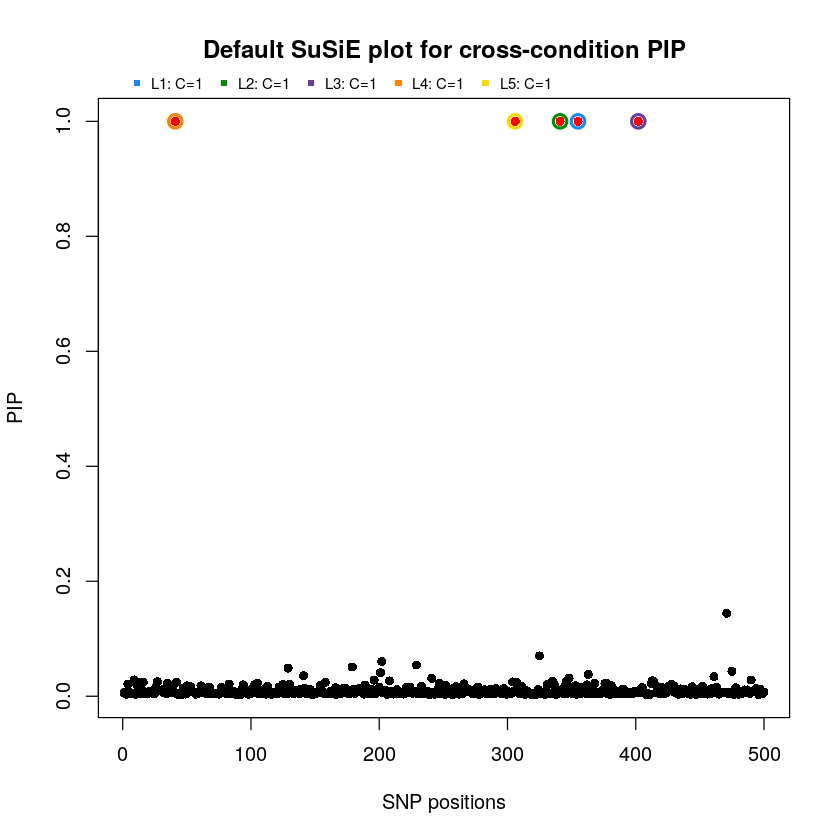

In [9]:
susieR::susie_plot(res,y='PIP', main = 'Default SuSiE plot for cross-condition PIP', xlab = 'SNP positions', add_legend = T, b=true_pos)

## Estimating prior variance scalar directly

In [10]:
start = Sys.time()
res2 = mvsusieR::mvsusie(dat$X,dat$y,L=L,prior_variance=dat$V,compute_objective=T,estimate_residual_variance=F,estimate_prior_variance=T, estimate_prior_method='optim')
Sys.time() - start

Time difference of 4.452133 mins

In [11]:
res2$elbo

[1] -1624.325 -1572.592 -1571.963 -1571.955 -1571.954

The ELBO is indeed better, but it takes much longer time -- per iteration time is about **50 times** compared to when the scalar is not estimated. 

The estimated scalars for prior variance are:

In [12]:
res2$V

[1] 0.5686575 0.5031943 0.4454950 0.4840251 0.5339320 0.0000000 0.0000000
 [8] 0.0000000 0.0000000 0.0000000

As expected only the first 5 effects are non-zero.

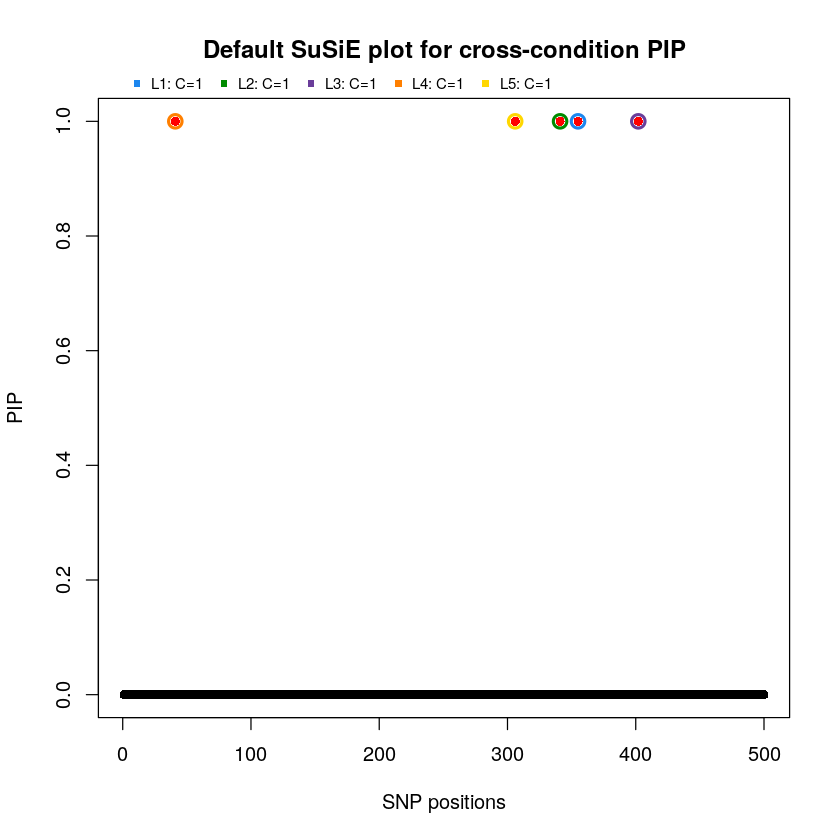

In [13]:
susieR::susie_plot(res2,y='PIP', main = 'Default SuSiE plot for cross-condition PIP', xlab = 'SNP positions', add_legend = T, b=true_pos)

The PIP plot also appears a lot cleaner.

## "Simple" method to estimate prior

Here instead of estimating prior scalar I only compare it with setting it to zero:

In [14]:
start = Sys.time()
res2 = mvsusieR::mvsusie(dat$X,dat$y,L=L,prior_variance=dat$V,compute_objective=T,estimate_residual_variance=F,estimate_prior_variance=T, estimate_prior_method='simple')
Sys.time() - start

Time difference of 19.3359 secs

In [15]:
res2$elbo

[1] -1618.744 -1574.431 -1574.174 -1574.171 -1574.171

In [16]:
res2$V

[1] 1 1 1 1 1 0 0 0 0 0

It's a lot faster but the ELBO is slighly smaller.

## EM update for prior scalar

In [17]:
start = Sys.time()
res2 = mvsusie(dat$X,dat$y,L=L,prior_variance=dat$V,compute_objective=T,estimate_residual_variance=F,estimate_prior_variance=T, estimate_prior_method='EM')
Sys.time() - start

Time difference of 23.36678 secs

In [18]:
res2$elbo

[1] -1655.505 -1580.760 -1573.059 -1571.975 -1571.955 -1571.954

In [19]:
res2$V

[1] 0.5686551 0.5030508 0.4454906 0.4840045 0.5339213 0.0000000 0.0000000
 [8] 0.0000000 0.0000000 0.0000000

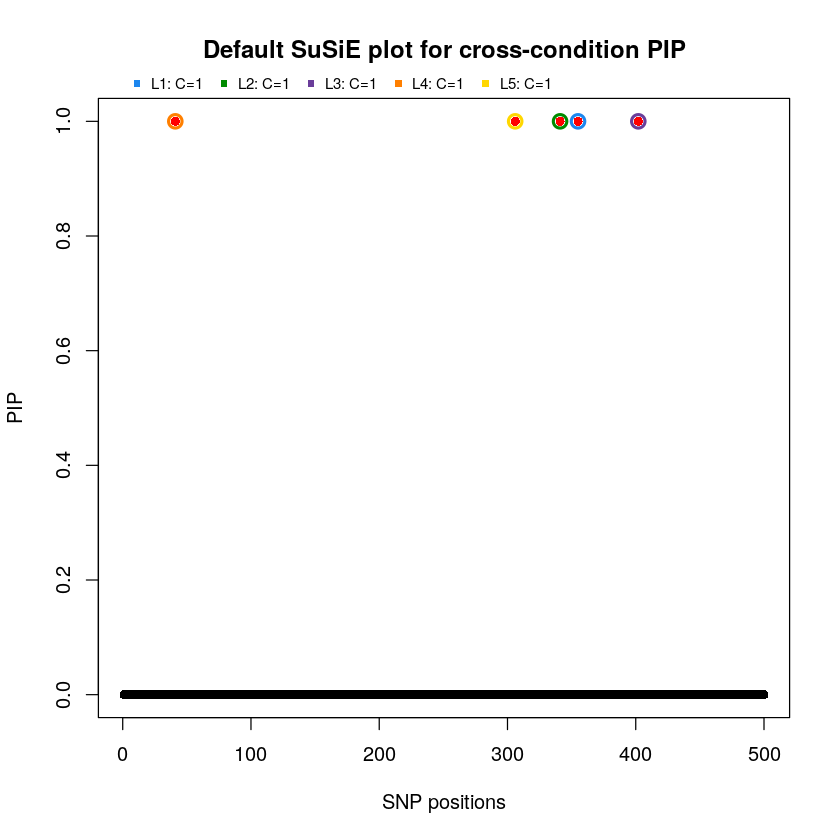

In [20]:
susieR::susie_plot(res2,y='PIP', main = 'Default SuSiE plot for cross-condition PIP', xlab = 'SNP positions', add_legend = T, b=true_pos)

Almost same result as using `optim` method.

## Update for prior scalar for MASH mixture

First, try out the `simple` method in MASH to verify that it agrees with the multivariate prior (although it does, at least as far as our unit test can tell us),

In [21]:
start = Sys.time()
m_init = mvsusieR:::MashInitializer$new(list(dat$V), 1, 1, 0)
res2 = mvsusie(dat$X,dat$y,L=L,prior_variance=m_init,estimate_prior_variance=T,precompute_covariances=T,compute_objective=T,estimate_residual_variance=F, estimate_prior_method='simple')
Sys.time() - start

Time difference of 2.153718 secs

In [22]:
res2$elbo

[1] -1618.744 -1574.431 -1574.174 -1574.171 -1574.171

In [23]:
res2$V

[1] 1 1 1 1 1 0 0 0 0 0

Now try `EM` method and see that agrees with the multivariate prior (although it does, at least as far as our unit test can tell us),

In [24]:
start = Sys.time()
m_init = mvsusieR:::MashInitializer$new(list(dat$V), 1, 1, 0)
res2 = mvsusie(dat$X,dat$y,L=L,prior_variance=m_init,estimate_prior_variance=T,precompute_covariances=F,compute_objective=T,estimate_residual_variance=F, estimate_prior_method='EM')
Sys.time() - start

Time difference of 2.964305 secs

In [26]:
res2$elbo

[1] -1655.505 -1580.760 -1573.059 -1571.975 -1571.955 -1571.954

In [27]:
res2$V

[1] 0.5686551 0.5030508 0.4454906 0.4840045 0.5339213 0.0000000 0.0000000
 [8] 0.0000000 0.0000000 0.0000000